## Ensemble learning

In [30]:
import quandl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM, GMMHMM
import scipy
import datetime
import json
import seaborn as sns
import joblib
import quandl
from dateutil.relativedelta import relativedelta

import yfinance as yf
import plotly.express as px
from statistics import mode
import pickle
import glob

import warnings
warnings.filterwarnings("ignore")

In [80]:
# Majority Voting

def majorityEnsemble(files=[], train_test_split_date='2018-01-01 00:00:00', states={'bull': 1, 'bear': -1, 'static': 0}, baseline='hmm_baseline'):
    """
        files (list): list of pickle files to consider in 'output' folder; 
            if this list is empty, read all pickle files in folder
        train_test_split_date (str): start date of test set
    """    

    ####### SETUP FILE PATHS #######

    if len(files) == 0:
        raise Exception('No files provided')
    else:
        files.append(baseline)
        raw_files_train = ['/data/workspace_files/output/{}_train.pickle'.format(f.replace('.pickle', '')) for f in files]
        raw_files_test = ['/data/workspace_files/output/{}_test.pickle'.format(f.replace('.pickle', '')) for f in files]

    model_names = [f.split('/')[-1].replace('.pickle', '') for f in files]

    if len(raw_files_train) == 0 or len(raw_files_test) == 0:
        raise Exception('Could not find required files in output folder')

    ####### READ FILES INTO COMMON DF #######

    df_close = pd.read_pickle('/data/workspace_files/data_close.pickle')
    df_ret = pd.read_pickle('/data/workspace_files/data_fut_return.pickle')
    df_train, df_test = df_ret[df_ret.index < train_test_split_date], df_ret[df_ret.index >= train_test_split_date]

    for name, train_path, test_path in zip(model_names, raw_files_train, raw_files_test):
        print('Reading model file: ' + name)
        df_train_temp = pd.read_pickle(train_path)
        df_test_temp = pd.read_pickle(test_path)

        if len(df_train_temp.columns) != 1:
            raise Exception('Error reading train file: expected 1 column but loaded {} columns'.format(len(df_train_temp.columns)))
        if len(df_test_temp.columns) != 1:
            raise Exception('Error reading test file: expected 1 column but loaded {} columns'.format(len(df_test_temp.columns)))
        df_train_temp.columns = [name]
        df_test_temp.columns = [name]
        df_train = df_train.join(df_train_temp, how='left')
        df_test = df_test.join(df_test_temp, how='left')

    df_train = df_train.fillna(0)
    if df_test.isnull().values.any():
        raise Exception('Null values detected in test joined dataframe')

    def _ensemble(models, baseline):
        model_names = [m for m in models if m != baseline]
        def f(df):
            arr = [df[name] for name in model_names]
            # count = 0
            # for x in arr:
            #     if x == states['static']:
            #         count = count + 1
            # if np.sum(arr) == 0 or count==2:
            #     return 0

            return mode([df[name] for name in model_names])

        return f

    ####### SETUP RETURN ACTIONS; calculate returns using future_return column #######
    ret = []

    for df, lab in zip([df_train, df_test], ['train', 'test']):
        df['benchmark'] = states['bull']
        df['ensemble'] = df.apply(_ensemble(model_names, baseline), axis=1)
        df[['ensemble']].to_pickle('/data/workspace_files/output/ensemble_{}.pickle'.format(lab))
        model_names_full = ['benchmark', *model_names, 'ensemble']
        return_labels = ['benchmark' if name == 'benchmark' \
                        else 'model_{}'.format(name) for name in model_names_full]
                            
        df[model_names_full] = df[model_names_full].astype(int)
        
        for model, label in zip(model_names_full, return_labels):
            actions = np.select([
                (df[model] == states['bull']),
                (df[model] == states['bear']),
                (df[model] == states['static'])],
                [1, -1, 0]
            )
            df[label] = actions
            df[label] = 100* ((df[label] * df['future_return']) + 1).cumprod()
        ret = ret + [df, return_labels]
    df_train, train_labels, df_test, test_labels = ret
    return df_train, train_labels, df_test, test_labels

df_train, train_labels, df, labels = majorityEnsemble(['lstm', 
                               'MSM',
                               #'hmm_spca92.pickle', 
                               'hmm_pca92',
                               #'hmm_baseline'
                               #'hmm_last_return.pickle',
                               #'hmm_spca99_test.pickle',
                               #'hmm_spca11_test.pickle',
                               ])

Reading model file: lstm
Reading model file: MSM
Reading model file: hmm_pca92
Reading model file: hmm_baseline


In [81]:
px.line(df[labels], title='Performance of Simple Strategy', labels={'index': 'Date', 'value': 'Cumulative Return'})

Unsupported

In [69]:
rf_df = pd.read_pickle('/data/workspace_files/data_rf.pickle')
test_set_res = pd.merge_asof(df, rf_df, right_index=True, left_index=True)

df_summary = pd.DataFrame()
final = {}

for column in labels:
    df_returns = test_set_res[column].pct_change()
    s = {}
    year_count = relativedelta(test_set_res['RF'].index[-1], test_set_res['RF'].index[0]).years
    rf = (1 + test_set_res['RF']/365).prod() ** (1/ year_count) - 1
    s['Mean Return'] = np.exp(np.log(test_set_res[column]/test_set_res[column].shift(1)).mean() *52) - 1
    s['Volatility'] = df_returns.std() * np.sqrt(52)
    s['Skewness'] = df_returns.skew()
    s['Kurtosis'] = df_returns.kurtosis()
    s['Maximum Drawdown'] = (test_set_res[column]/test_set_res[column].cummax()-1).min()
    s['Sharpe Ratio'] = (s['Mean Return'] - rf) / s['Volatility']
    # s['Adjusted_Sharpe_Ratio'] = s['Sharpe Ratio']*(1+s['Skewness']/6*s['Sharpe Ratio']-(s['Kurtosis']-3)/24*s['Sharpe Ratio']**2)
    s['Semi-Deviation'] = df_returns[df_returns < df_returns.mean()].std()*np.sqrt(52)
    s['1-month Autocorrelation'] = df_returns.autocorr(lag=1)
    s['3-month Autocorrelation'] = df_returns.autocorr(lag=3)
    s['1-year Autocorrelation'] = df_returns.autocorr(lag=12)    
    final[column] = s

df_summary = pd.DataFrame.from_dict(final, orient='index').round(4).T
# df_summary.to_csv('res.csv')

#cols = ['benchmark_return', 'hmm_baseline_return', 'lstm_return', 'MSM_return', 'hmm_pca92_return', 'ensemble_return']
#labels = ['Benchmark', 'Baseline', 'LSTM', 'MSM', 'HMM PCA', 'Ensemble']

cols = ['model_benchmark', 'model_lstm', 'model_MSM', 'model_hmm_pca92','model_hmm_baseline', 'model_ensemble']
labels = ['Benchmark', 'LSTM', 'MSM', 'HMM PCA', 'Baseline', 'Ensemble']

df_summary = df_summary.rename(columns={k:v for k,v in zip(cols, labels)})[labels]
df_summary

,Benchmark,LSTM,MSM,HMM PCA,Baseline,Ensemble
Mean Return,0.1577,0.4845,0.3406,0.0676,0.1236,0.4807
Volatility,0.1580,0.1491,0.1419,0.1139,0.1533,0.1490
Skewness,-1.3324,1.2587,0.7900,-0.1766,0.5905,0.8621
Kurtosis,7.5491,6.6545,10.4265,3.1473,7.1940,7.3056
Maximum Drawdown,-0.2860,-0.0799,-0.1962,-0.2124,-0.3600,-0.1795
Sharpe Ratio,0.9878,3.2386,2.3881,0.5792,0.7960,3.2145
Semi-Deviation,0.1393,0.0830,0.1032,0.0841,0.1092,0.0959
1-month Autocorrelation,0.1642,0.0243,0.0476,0.1467,0.1396,0.0995
3-month Autocorrelation,-0.0511,0.0355,0.0960,-0.0830,-0.1590,-0.0092
1-year Autocorrelation,-0.0287,0.0234,-0.0595,0.0863,0.0406,0.0600


In [70]:
print(df_summary.round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Benchmark &  LSTM &    MSM &  HMM PCA &  Baseline &  Ensemble \\
\midrule
Mean Return             &       0.16 &  0.48 &   0.34 &     0.07 &      0.12 &      0.48 \\
Volatility              &       0.16 &  0.15 &   0.14 &     0.11 &      0.15 &      0.15 \\
Skewness                &      -1.33 &  1.26 &   0.79 &    -0.18 &      0.59 &      0.86 \\
Kurtosis                &       7.55 &  6.65 &  10.43 &     3.15 &      7.19 &      7.31 \\
Maximum Drawdown        &      -0.29 & -0.08 &  -0.20 &    -0.21 &     -0.36 &     -0.18 \\
Sharpe Ratio            &       0.99 &  3.24 &   2.39 &     0.58 &      0.80 &      3.21 \\
Semi-Deviation          &       0.14 &  0.08 &   0.10 &     0.08 &      0.11 &      0.10 \\
1-month Autocorrelation &       0.16 &  0.02 &   0.05 &     0.15 &      0.14 &      0.10 \\
3-month Autocorrelation &      -0.05 &  0.04 &   0.10 &    -0.08 &     -0.16 &     -0.01 \\
1-year Autocorrelation  &      -0.03 &  0.02 &  -0.06 &   

In [71]:
pd.read_pickle('/data/workspace_files/output/lstm_test.pickle')

,lstm
Date,
2018-01-01,1
2018-01-08,1
2018-01-15,1
2018-01-22,1
2018-01-29,1
...,...
2021-12-06,-1
2021-12-13,-1
2021-12-20,-1


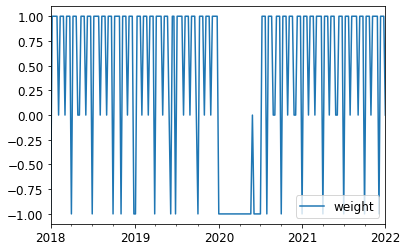

In [72]:
pd.read_pickle('/data/workspace_files/output/hmm_spca99_test.pickle').plot()

# Trading Strategy with vol timing

In [73]:
vix_df = pd.read_pickle('/data/workspace_files/data_vix.pickle') 
rf_df = pd.read_pickle('/data/workspace_files/data_rf.pickle') 
close_df = pd.read_pickle('/data/workspace_files/data_close.pickle')
fut_return = pd.read_pickle('/data/workspace_files/data_fut_return.pickle')

In [74]:
def get_risk_params(train_df_w_signal, states_map, regime_list=['buy', 'neutral', 'sell']):
    """
    Function to get the risk aversion and risk premium in different regimes.

    Inputs:
        train_df_w_signal : DataFrame - Training period with columns ['signal', 'future_return'], 
                            index as datetime
        states_map : Dict<{str : int})> - Mapping of regimes to numerical signals
        regime_list : List<str> - List of regimes

    Output:
        risk_aversion : Dict<{str : float}> - Value of absolute risk aversion coefficient 
                        based on current regime
        risk_premium : Dict<{str : float}> - Value of equity risk premium based on 
                        current regime
    """
    df = pd.merge_asof(train_df_w_signal, vix_df / 100, right_index=True, left_index=True)
    df = pd.merge_asof(df, rf_df, right_index=True, left_index=True)
    df = pd.merge_asof(df, fut_return, right_index=True, left_index=True)
    risk_aversion = dict()
    risk_premium = dict()

    for regime in regime_list:
        regime_vix_mean  = df[df.signal == states_map[regime]].VIX.mean()
        risk_aversion[regime] = 3 / df.VIX.mean() * regime_vix_mean

        # return mean has to be geometric mean! 
        regime_return_mean = df[df.signal == states_map[regime]].future_return.mean()
        risk_premium[regime] =  regime_return_mean*52 - df.RF.mean()
    return risk_aversion, risk_premium

def mean_variance_weight(vol, signal, risk_aversion, risk_premium, signal_map):
    """
    Function to get weight at a timestamp based on the regime.

    Inputs:
        vol : <float> - value of current volatility (annualized)
        signal : <int> - current signal value
        risk_aversion : Dict<str> - Value of absolute risk aversion coefficient based on 
                        current regime
        risk_premium : Dict<{str : float}> - Value of equity risk premium based on 
                        current regime
        signal_map : Dict<{int : str}> - Mapping of numerical signals to regimes

    Output:
        weight : <float> capped weight of asset allocation for the strategy
    """
    var = vol**2
    rpremia = (risk_premium[signal_map[signal]])
    r_av = 1 / risk_aversion[signal_map[signal]]
    weight= np.divide(r_av * rpremia, var)
    return weight

def get_strategy_weights(test_df_w_signal, 
                         signal_map, 
                         risk_aversion, 
                         risk_premium, 
                         strategy='vol-timing'):
    """
    Function to get the weight allocation series for the strategy.

    Inputs:
        test_df_w_signal : DataFrame - Test period with columns ['signal'], index as datetime
        signal_map : Dict<{int : str}> - Mapping of numerical signals to regimes
        risk_aversion : Dict<str> - Value of absolute risk aversion coefficient based on 
                        current regime
        risk_premium : Dict<{str : float}> - Value of equity risk premium based on current regime
        strategy : <str> - Trading strategy, must be one out of ['vol-timing', 'full-allocation']

    Output:
        risk_aversion : Dict<{str : float}> - Value of absolute risk aversion coefficient based on 
                        current regime
        risk_premium : Dict<{str : float}> - Value of equity risk premium based on current regime
    """
    df = pd.merge_asof(test_df_w_signal, vix_df / 100, right_index=True, left_index=True)
    weights = None
    if strategy=='full-allocation':
        weights = df.signal
    elif strategy=='vol-timing':
        weights = [mean_variance_weight(vol, int(signal), risk_aversion, risk_premium, signal_map)
                    for i, (vol, signal) in df[['VIX','signal']].iterrows()]
    
    return np.minimum(np.maximum(weights, -1), 1)

In [75]:
### use this to convert states_map to signal_map
states_map = {
    'buy' : 1,
    'neutral' : 0,
    'sell' : -1
}
signal_map = {v: k for k, v in states_map.items()}
initial_capital = 100 

# models = ['lstm','MSM','hmm_last_return','hmm_pca92','hmm_spca11','hmm_spca92','hmm_spca99', 'ensemble'] # Placeholder
models = ['lstm','MSM', 'hmm_pca92', 'ensemble', 'hmm_baseline'] # Placeholder

## ANY MODEL JUST TO GET TIME INDEX
test_df_w_signal = pd.read_pickle('/data/workspace_files/output/lstm_test.pickle')
test_set_res = pd.DataFrame(index=test_df_w_signal.index)
test_set_res = pd.merge_asof(test_set_res, fut_return, right_index=True, left_index=True)

for model in models:
    print('processing model {}'.format(model))
    train_df_w_signal = pd.read_pickle('/data/workspace_files/output/{}_train.pickle'.format(model))
    test_df_w_signal = pd.read_pickle('/data/workspace_files/output/{}_test.pickle'.format(model))
    # if model in ['MSM']:
    #     train_df_w_signal.drop(columns=['future_return'], inplace=True)
    #     test_df_w_signal.drop(columns=['future_return'], inplace=True)

    train_df_w_signal.columns=['signal']
    test_df_w_signal.columns=['signal']

    risk_aversion, risk_premium = get_risk_params(train_df_w_signal, states_map)
    #print(risk_aversion, risk_premium)
    test_df_w_signal['weight'] = get_strategy_weights(test_df_w_signal, 
                                 signal_map, risk_aversion, risk_premium,
                                )
                                # strategy='full-allocation')
    # test_df_w_signal['weight'] = get_strategy_weights(test_df_w_signal, 
    #signal_map, risk_aversion, risk_premium, strategy='full-allocation')

    # test_set_res = pd.DataFrame(index=test_df_w_signal.index)
    # test_set_res = pd.merge_asof(test_set_res, fut_return, right_index=True, left_index=True)
    test_set_res['model_{}'.format(model)] = 0
    test_set_res['model_{}'.format(model)].iloc[0] = initial_capital
    
    v_t = initial_capital
    ### Model Out-of-Sample PnL
    for i in range(test_set_res.shape[0]-1):
        v_t = v_t * (1 + test_set_res['future_return'].iloc[i] * test_df_w_signal['weight'].iloc[i])
        test_set_res['model_{}'.format(model)].iloc[i+1] = v_t

test_set_res['benchmark'] = 100 * (test_set_res['future_return'] + 1).cumprod()
test_set_res = test_set_res.drop(columns=['future_return'])
#px.line(test_set_res)
px.line(test_set_res, title='Performance of Vol-timing Strategy', labels={'value': 'Cumulative Return'})

processing model lstm
processing model MSM
processing model hmm_pca92
processing model ensemble
processing model hmm_baseline


Unsupported

In [47]:
test_set_res = pd.merge_asof(test_set_res, rf_df, right_index=True, left_index=True)
columns = ['model_{}'.format(model) for model in models] + ['benchmark']

df_summary = pd.DataFrame()
final = {}

for column in columns:
    df_returns = test_set_res[column].pct_change()
    s = {}
    year_count = relativedelta(test_set_res['RF'].index[-1], test_set_res['RF'].index[0]).years
    rf = (1 + test_set_res['RF']/365).prod() ** (1/ year_count) - 1
    s['Mean Return'] = np.exp(np.log(test_set_res[column]/test_set_res[column].shift(1)).mean() *52) - 1
    s['Volatility'] = df_returns.std() * np.sqrt(52)
    s['Skewness'] = df_returns.skew()
    s['Kurtosis'] = df_returns.kurtosis()
    s['Maximum Drawdown'] = (test_set_res[column]/test_set_res[column].cummax()-1).min()
    s['Sharpe Ratio'] = (s['Mean Return'] - rf) / s['Volatility']    
    s['Semi-Deviation'] = df_returns[df_returns < df_returns.mean()].std()*np.sqrt(52)
    s['1-month Autocorrelation'] = df_returns.autocorr(lag=1)
    s['3-month Autocorrelation'] = df_returns.autocorr(lag=3)
    s['1-year Autocorrelation'] = df_returns.autocorr(lag=12)
    s
    final[column] = s

df_summary = pd.DataFrame.from_dict(final, orient='index').round(4).T
# df_summary.to_csv('res.csv')
# models = ['lstm','MSM', 'hmm_pca92', 'ensemble', 'hmm_baseline'] # Placeholder
cols = ['benchmark', 'model_hmm_baseline', 'model_lstm', 'model_MSM', 'model_hmm_pca92', 'model_ensemble']
labels = ['Benchmark', 'Baseline', 'LSTM', 'MSM', 'HMM PCA', 'Ensemble']

df_summary = df_summary.rename(columns={k:v for k,v in zip(cols, labels)})[labels]
df_summary

,Benchmark,Baseline,LSTM,MSM,HMM PCA,Ensemble
Mean Return,0.1577,0.1221,0.4396,0.3640,0.0630,0.4667
Volatility,0.1580,0.0957,0.1284,0.1280,0.0819,0.1319
Skewness,-1.3324,-1.1279,0.6635,0.1646,-1.9465,0.5757
Kurtosis,7.5491,5.4747,1.8391,4.0882,9.0980,2.6945
Maximum Drawdown,-0.2860,-0.0817,-0.0542,-0.1344,-0.1015,-0.1104
Sharpe Ratio,0.9878,1.2586,3.4105,2.8306,0.7489,3.5253
Semi-Deviation,0.1393,0.0799,0.0720,0.0940,0.0772,0.0802
1-month Autocorrelation,0.1642,0.0677,0.0566,0.0443,0.1117,0.0440
3-month Autocorrelation,-0.0511,-0.0555,0.0369,0.0443,-0.0147,0.0194
1-year Autocorrelation,-0.0287,0.0627,0.0097,-0.0616,0.0069,0.0454


In [48]:
print(df_summary.round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Benchmark &  Baseline &  LSTM &   MSM &  HMM PCA &  Ensemble \\
\midrule
Mean Return             &       0.16 &      0.12 &  0.44 &  0.36 &     0.06 &      0.47 \\
Volatility              &       0.16 &      0.10 &  0.13 &  0.13 &     0.08 &      0.13 \\
Skewness                &      -1.33 &     -1.13 &  0.66 &  0.16 &    -1.95 &      0.58 \\
Kurtosis                &       7.55 &      5.47 &  1.84 &  4.09 &     9.10 &      2.69 \\
Maximum Drawdown        &      -0.29 &     -0.08 & -0.05 & -0.13 &    -0.10 &     -0.11 \\
Sharpe Ratio            &       0.99 &      1.26 &  3.41 &  2.83 &     0.75 &      3.53 \\
Semi-Deviation          &       0.14 &      0.08 &  0.07 &  0.09 &     0.08 &      0.08 \\
1-month Autocorrelation &       0.16 &      0.07 &  0.06 &  0.04 &     0.11 &      0.04 \\
3-month Autocorrelation &      -0.05 &     -0.06 &  0.04 &  0.04 &    -0.01 &      0.02 \\
1-year Autocorrelation  &      -0.03 &      0.06 &  0.01 & -0.06 &  

# PLOT 

In [91]:
def plot_hidden_states(hidden_states, close_series, fut_ret_series):
    matplotlib.rcParams.update({'font.size': 12})
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(3, 2, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 0.5, 3))

    ret_list = []
    for i, (ax, colour) in enumerate(zip(axs, ['red', 'blue', 'green'])):
        mask = hidden_states[hidden_states.iloc[:, 0] == i-1].index
        ax[0].plot(close_series.index, close_series, c = 'grey')
        ax[0].plot(close_series.loc[mask].index, close_series.loc[mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i), fontsize = 18)
        ax[0].grid(True)

        cum_return = (fut_ret_series.loc[mask] + 1).cumprod()
        ax[1].plot(cum_return, c = colour)
        ax[1].set_title("cummulative future return at {0}th hidden state".format(i), fontsize = 18)
        ax[1].grid(True)
        
        ret_list.append(cum_return.iloc[-1].squeeze())
    plt.tight_layout()
    
    fig.savefig('/data/workspace_files/classification.png')
    return ret_list

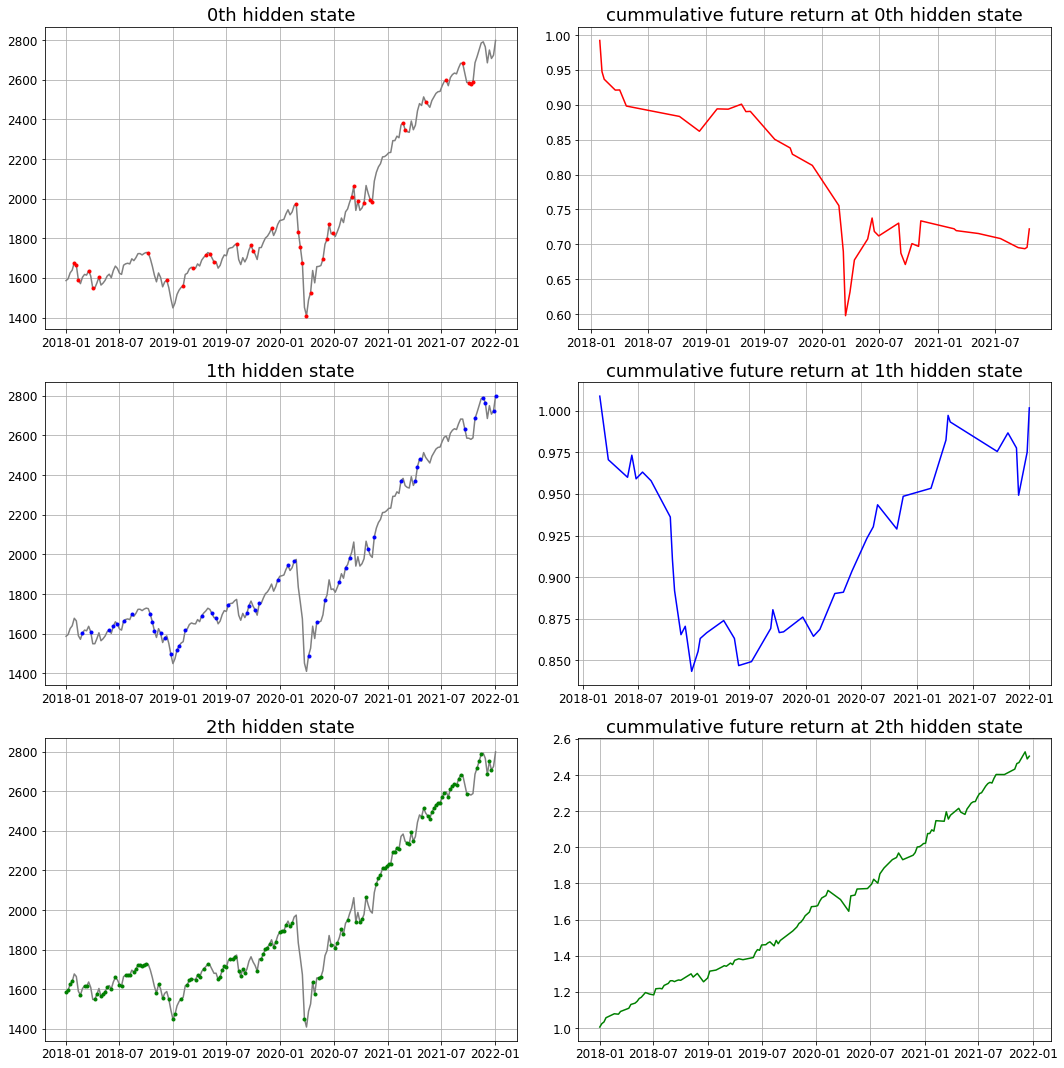

In [92]:
hidden_states = pd.read_pickle('/data/workspace_files/output/MSM_test.pickle')
df_ret = pd.read_pickle('/data/workspace_files/data_fut_return.pickle').loc[hidden_states.index]
df_close = pd.read_pickle('/data/workspace_files/data_close.pickle').loc[hidden_states.index]
plot_hidden_states(hidden_states, df_close, df_ret)